## Машинное обучение, ВМК МГУ, 318 группа, 2021 г.

## Практическое задание 8

### Общая информация
Дата выдачи: 7 апреля 2021 г.
Дедлайн: 13 апреля 2021 г.

### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии
- реализуете логистическую регрессию и её обучение градиентным спуском
- настроите метод опорных векторов, визуализируете опорные вектора
- познакомитесь с калибровочными кривыми и сравните вероятности, выдаваемые логистической регрессией и методом опорных векторов
- изучите методы работы с категориальными переменными

In [1]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Линейная регрессия

В этой части мы кратко познакомимся с линейной регрессией.

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3.

In [2]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=318)

__Задание 1.__ Обучение линейной регрессии.

Обучите линейную регрессию с $L_1$ (Lasso, http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) и $L_2$ (Ridge, http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$). Согласуются ли результаты с вашими ожиданиями?

In [3]:
count_zeros = lambda x: len([elem for elem in x if abs(elem) < 1e-3])
count_not_zeros = lambda x: len([elem for elem in x if abs(elem) > 1e-3])

Zero coeff in lasso model: 8
Zero coeff in ridge model: 0


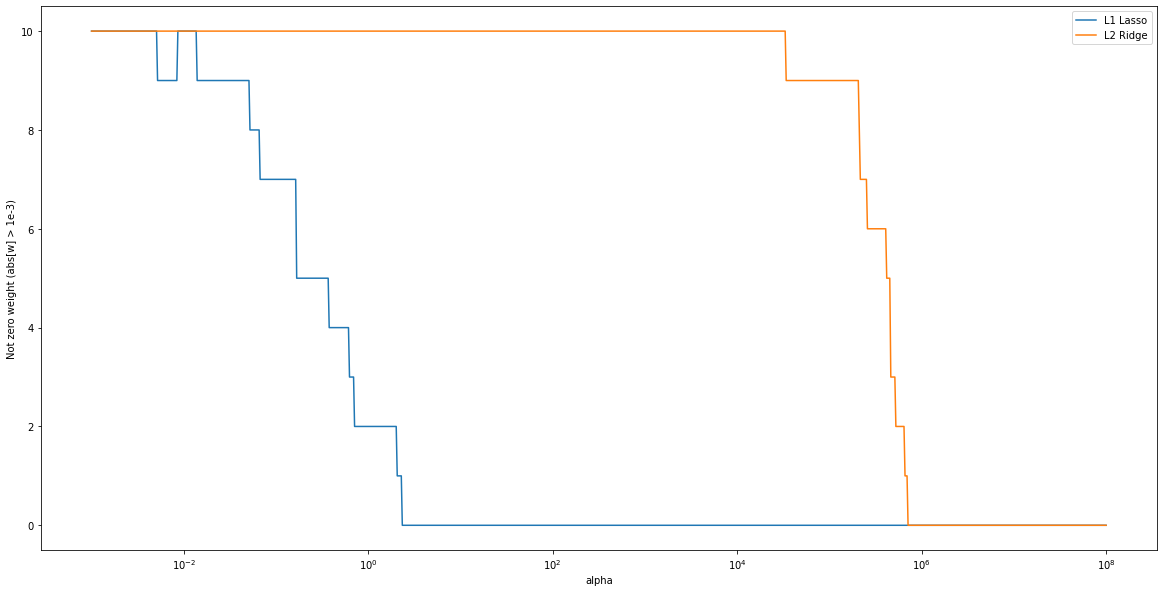

In [4]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso()
lasso.fit(X_train, y_train)

ridge = Ridge()
ridge.fit(X_train, y_train)

print("Zero coeff in lasso model:", count_zeros(lasso.coef_))
print("Zero coeff in ridge model:", count_zeros(ridge.coef_))


parametrs = [10 ** i for i in np.linspace(-3, 8, num = 1000)]

zeros_lasso = []
zeros_ridge = []

for elem in parametrs:
    lasso = Lasso(alpha = elem)
    lasso.fit(X_train, y_train)
    non_zeros = count_not_zeros(lasso.coef_)
    zeros_lasso.append(non_zeros)
    
    ridge = Ridge(alpha = elem)
    ridge.fit(X_train, y_train)
    non_zeros = count_not_zeros(ridge.coef_)
    zeros_ridge.append(non_zeros)

plt.subplots(figsize=(20, 10))
plt.plot(parametrs, zeros_lasso, label = "L1 Lasso")
plt.plot(parametrs, zeros_ridge, label = "L2 Ridge")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("Not zero weight (abs[w] > 1e-3)")
plt.legend()
plt.show()

Результаты согласуются с ожиданиями: L1 регуляризация обнуляет веса с увеличением параметра регуляризации. L2 регуляризация для большого параметра регуляризации делает почти нулевыми все веса.


Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

ridge = Ridge()
ridge.fit(X_train, y_train)

print("\t Train")
y_pred = ridge.predict(X_train)
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))
print("MAE :", mean_absolute_error(y_train, y_pred))
print("R2  :", r2_score(y_train, y_pred))


print("\t Test")
y_pred = ridge.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("R2  :", r2_score(y_test, y_pred))

	 Train
RMSE: 58.701868134770876
MAE : 49.573419650386725
R2  : 0.43081411178357476
	 Test
RMSE: 57.61427963381135
MAE : 47.7824170753989
R2  : 0.41154718374963595


Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Для этого воспользуйтесь GridSearchCV и KFold из sklearn. Обратите внимание, какие метрики должны минимизироваться, а какие максимизироваться. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

In [6]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer

parametrs = {'alpha': [10**i for i in np.linspace(-3, 3, num = 200)]}


my_score = make_scorer(mean_squared_error, greater_is_better=False)
grid = GridSearchCV(Ridge(), parametrs, scoring = my_score, cv = 2) 
grid.fit(X_train, y_train)
print("Best alpha for RMSE:", grid.best_params_['alpha'])


my_score = make_scorer(mean_absolute_error, greater_is_better=False)
grid = GridSearchCV(Ridge(), parametrs, scoring = my_score, cv = 2) 
grid.fit(X_train, y_train)
print("Best alpha for MAE: ", grid.best_params_['alpha'])


my_score = make_scorer(r2_score, greater_is_better=True)   #чем ближе к 1, тем лучше
grid = GridSearchCV(Ridge(), parametrs, scoring = my_score, cv = 2) 
grid.fit(X_train, y_train)
print("Best alpha for R2:  ", grid.best_params_['alpha'])

Best alpha for RMSE: 0.001
Best alpha for MAE:  0.001
Best alpha for R2:   0.001


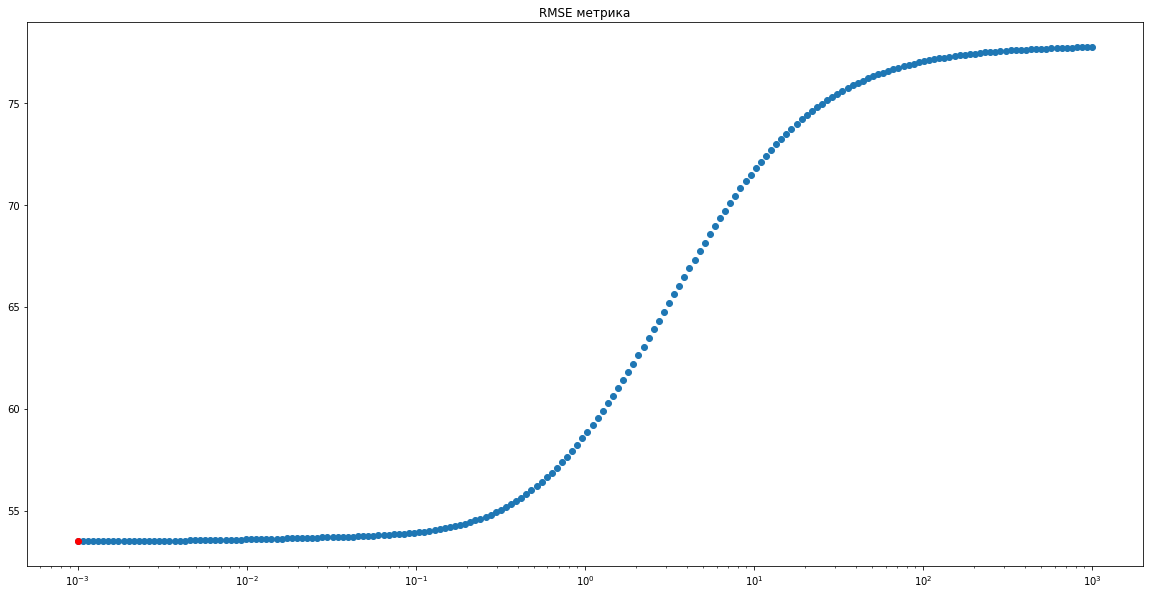

Best alpha: 0.001
Best RMSE 53.49774079493744


In [7]:
x = [10**i for i in np.linspace(-3, 3, num = 200)]
y = np.array([])

fig, ax = plt.subplots(figsize=(20, 10))
plt.xscale('log')
minimum = 10 ** 6
for elem in x:
    ridge = Ridge(alpha = elem)
    ridge.fit(X_train, y_train)
    
    y_pred = ridge.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    
    if rmse < minimum:
        minimum = rmse
        position = elem
    
    y = np.append(y, rmse) 

ax.scatter(x, y)
ax.set_title('RMSE метрика')
ax.scatter(position, minimum, color = 'red')
plt.show()
print('Best alpha:', position)
print('Best RMSE', minimum)
best_rmse = minimum

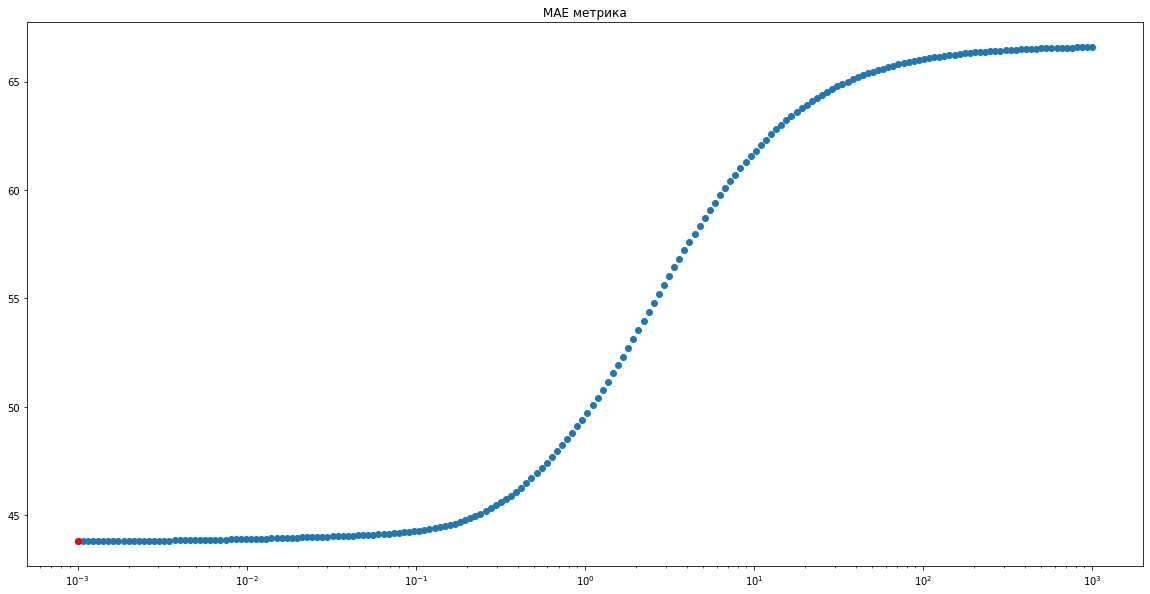

Best alpha: 0.001
Best MAE 43.80215701028072


In [8]:
x = [10**i for i in np.linspace(-3, 3, num = 200)]
y = np.array([])

fig, ax = plt.subplots(figsize=(20, 10))
plt.xscale('log')
minimum = 10 ** 6
for elem in x:
    ridge = Ridge(alpha = elem)
    ridge.fit(X_train, y_train)
    
    y_pred = ridge.predict(X_train)
    mae = mean_absolute_error(y_train, y_pred)
    
    if mae < minimum:
        minimum = mae
        position = elem
    
    y = np.append(y, mae) 


ax.scatter(x, y)
ax.set_title('MAE метрика')
ax.scatter(position, minimum, color = 'red')
plt.show()
print('Best alpha:', position)
print('Best MAE', minimum)
best_mae = minimum

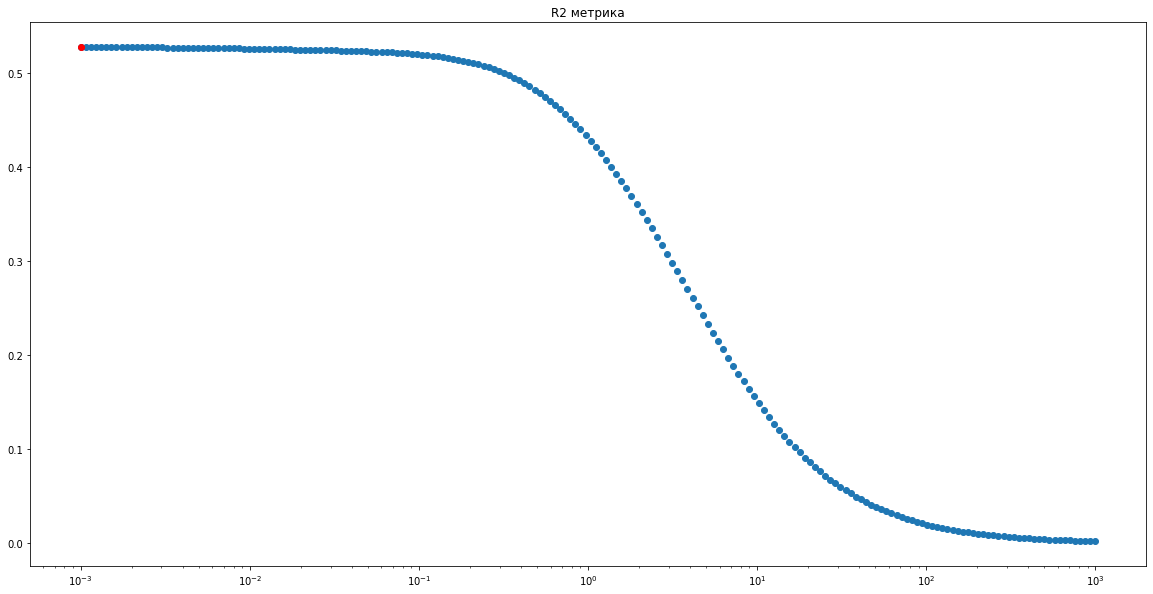

Best alpha: 0.001
Best R2 0.5272612924859096


In [9]:
x = [10**i for i in np.linspace(-3, 3, num = 200)]
y = np.array([])

fig, ax = plt.subplots(figsize=(20, 10))
plt.xscale('log')
maximum = 0
for elem in x:
    ridge = Ridge(alpha = elem)
    ridge.fit(X_train, y_train)
    
    y_pred = ridge.predict(X_train)
    r2 = r2_score(y_train, y_pred)
    
    if r2 > maximum:
        maximum = r2
        position = elem
    
    y = np.append(y, r2) 


ax.scatter(x, y)
ax.set_title('R2 метрика')
ax.scatter(position, maximum, color = 'red')
plt.show()
print('Best alpha:', position)
print('Best R2', maximum)
best_r2 = maximum

In [10]:
ridge = Ridge()
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("default rmse (alpha = 1.0):", rmse)
print("best rmse (alpha = 0.001) :", best_rmse, "(%1.2f%% better)" % ((best_rmse / rmse) * 100.0 - 100.0))

print("\ndefault mae (alpha = 1.0):", mae)
print("best mae (alpha = 0.001) :", best_mae, "(%1.2f%% better)" % ((best_mae / mae) * 100.0 - 100.0))

print("\ndefault r2 (alpha = 1.0):", r2)
print("best r2 (alpha = 0.001) :", best_r2, "(%1.2f%% better)" % ((best_r2 / r2) * 100.0 - 100.0))

default rmse (alpha = 1.0): 58.701868134770876
best rmse (alpha = 0.001) : 53.49774079493744 (-8.87% better)

default mae (alpha = 1.0): 49.573419650386725
best mae (alpha = 0.001) : 43.80215701028072 (-11.64% better)

default r2 (alpha = 1.0): 0.43081411178357476
best r2 (alpha = 0.001) : 0.5272612924859096 (22.39% better)


Качество изменилось заметно MSE(-9%), MAE(-12%), R2(+22%).
По граффикам видно, что в выборке однозначно есть выбросы (на некоторых сплитах параметр alpha отличается на порядок)

__Задание 2.__ Поиск объектов-выбросов

Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. С помощью cross_val_predict сделайте Out-of-Fold предсказания для обучающей выборки. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

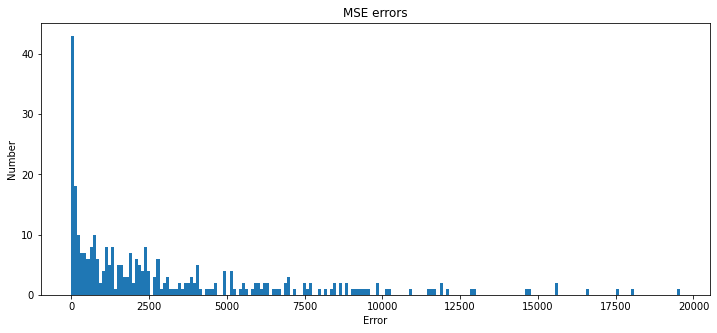

In [11]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(Ridge(alpha = 0.001), X_train, y_train, cv = 5)
plt.figure(figsize = (12, 5))
plt.title("MSE errors")
plt.ylabel("Number")
plt.xlabel("Error")
plt.hist((y_train-y_pred)**2, bins = 200)
plt.show()

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

Выкинем объекты с ошибкой больше 10000

In [14]:
X_new = X_train[(y_pred-y_train)**2 <= 10000]
y_new = y_train[(y_pred-y_train)**2 <= 10000]

y_predict_new = cross_val_predict(Ridge(alpha = 0.001), X_new, y_new, cv = 5)
y_predict_old = cross_val_predict(Ridge(alpha = 0.001), X_train, y_train, cv = 5)

print("\tИспользуя cross_val_predict")
print("Без выбросов \t\t С выбросами")
print("MAE:", mean_absolute_error(y_new, y_predict_new), mean_absolute_error(y_train, y_predict_old))
print("RMSE:", np.sqrt(mean_squared_error(y_new, y_predict_new)), np.sqrt(mean_squared_error(y_train, y_predict_old)))
print("R2 :", r2_score(y_new, y_predict_new), r2_score(y_train, y_predict_old))


y_predict_new = Ridge(alpha = 0.001).fit(X_new, y_new).predict(X_test)
y_predict_old = Ridge(alpha = 0.001).fit(X_train, y_train).predict(X_test)
print("\tНа отложенной выборке")
print("Без выбросов \t\t С выбросами")
print("MAE:", mean_absolute_error(y_test, y_predict_new), mean_absolute_error(y_test, y_predict_old))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_predict_new)), np.sqrt(mean_squared_error(y_test, y_predict_old)))
print("R2 :", r2_score(y_test, y_predict_new), r2_score(y_test, y_predict_old))

	Используя cross_val_predict
Без выбросов 		 С выбросами
MAE: 40.61163372000641 45.53876336063636
RMSE: 48.70503750190283 55.62469259264218
R2 : 0.5833172473397144 0.48892395315559656
	На отложенной выборке
Без выбросов 		 С выбросами
MAE: 43.48699044912528 42.718962464410005
RMSE: 54.686092413639955 54.03332872489166
R2 : 0.4698421975259319 0.4824231781261966


На отложенной выборке результаты MAE, RMSE при удалении выбросов изменяются слабо, так как сами выбросы предсказываются хуже, 
зато все остальные объекты лучше.
R2 метрика ухудшается, так как среднее значение, сильно зависит от выбросов. 
При использовании cross_val_predict рузультаты улучшаются.

## Часть 2. Логистическая регрессия

В этой части мы будем реализовывать один из самых простых бинарных классификаторов — логистическую регрессию и её обучение с помощью обычного (полного) и стохастического градиентных спусков.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). В случае стохастического градиентного спуска $\nabla_w Q(w, X) \approx \nabla_w q_{i_k} (w)$, где $i_k$ — случайно выбранный номер слагаемого из функционала (регуляризатор можно внести в сумму, предварительно умножив и разделив на $l$). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Вероятность принадлежности объекта $x$ классу $+1$ вычисляется следующим образом:

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- \langle w, x \rangle )}
$$

Не забывайте, что матрицу объекты-признаки $X$ необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из 2 способов, разобранных на лекциях). Для этого можно воспользоваться StandardScaler или сделать это вручную.

В логистической регрессии также можно использовать $L_1$-регуляризацию. Тогда в функцию потерь добавится слагаемое $\lambda_1 \lVert w \rVert _1$. В формуле для вычисления градиента фукнции потерь по вектору коэффициентов это слагаемое будет соответствовать $\lambda_1 sgn(w)$, где $sgn$ — вычисление знака числа, применяемое к вектору коэффициентов поэлементо.

__Задание 1.__ Реализация обучения и применения логистической регресии c $L_2$-регуляризацией. 

Используйте для этого указанные ниже прототипы. Для эффективности все вычисления производите в векторизованной форме без циклов (кроме самих итераций градиентного спуска). Сгенерируйте с помощью функции make\_classification из модуля sklearn.datasets небольшую выборку для тестирования и исследования (выборка не должна быть слишком простой для классификации; также не забудьте проверить, что метки объектов из необходимого нам множества). Постройте следующие графики (для полного и стохастического градиентного спуска на одном графике):
- функции потерь от номера итерации обучения
- затраченного времени от номера итерации обучения

Возьмите параметр регуляризации $\lambda_2=1$, точность $tolerance=10^{-6}$, максимальное число итераций $max\_iter=1000$. Подберите оптимальную на ваш взгляд величину шага градиентного спуска. 

Сделайте выводы о том, чем различается на практике обучение с помощью стохастического градиентного спуска по сравнению с полным градиентным спуском.

В этом задании не обращайте внимания на $\lambda_1$, соответствующий $L_1$-регуляризации.

Для численной устойчивости вам могут быть полезны функции: scipy.special.expit и numpy.logaddexp.

In [13]:
import math
import numpy as np
from scipy.special import expit

class LogReg(BaseEstimator):
    def __init__(self, lambda_1=0.0, lambda_2=1.0, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=0.1, alpha=1e-3):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.loss_history = None
        self.time_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        self.time_history = []
        start = time.time()
        
        count = 0
        self.w = np.ones((len(X[0]),))
        while np.linalg.norm(self.w-self.w0) > self.tolerance or count < self.max_iter:
            count += 1
            self.w = self.w0
            if self.gd_type == 'stochastic':
                i = random.randint(0, len(y))
                grad = self.calc_gradient(X[i:], np.array(y[i:]))
            else:
                grad = self.calc_gradient(X, y)
            self.w = self.w0 - self.alpha * grad
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            self.w0 = self.w
            self.time_history.append(time.time() - start)
        return self
    
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        y_pred = expit(np.dot(X, self.w))
        return y_pred
    
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        var1 = expit(-y * np.dot(X, self.w))
        var2 = y[:, np.newaxis] * X
        var3 = var1[:, np.newaxis] * var2
        var4 = -np.sum(var3, axis=0)
        grad = var4 / X.shape[0] + self.lambda_2 * self.w
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        n = X.shape[0]
        var1 = np.logaddexp(0, -y * np.dot(X, self.w))
        reg = self.lambda_2 * np.sum(self.w ** 2) / 2
        loss = (1 / n) * np.sum(var1, axis = 0)+ reg
        return loss
    

In [14]:
from sklearn.datasets import make_classification
from sklearn.metrics import average_precision_score, roc_auc_score

random.seed(1000)
X, y = make_classification(n_samples=1000, n_features=7)
n, m = X.shape
w0 = np.random.uniform(low=-10, high=10, size=(m,))
model = LogReg(w0=w0, max_iter=10000, gd_type='full', tolerance=10**(-7))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
roc = roc_auc_score(y_test, y_pred)
average = average_precision_score(y_test, y_pred)
print(roc, average)

0.964164886039886 0.9464356685230761


### Функция потерь от номера итерации обучения

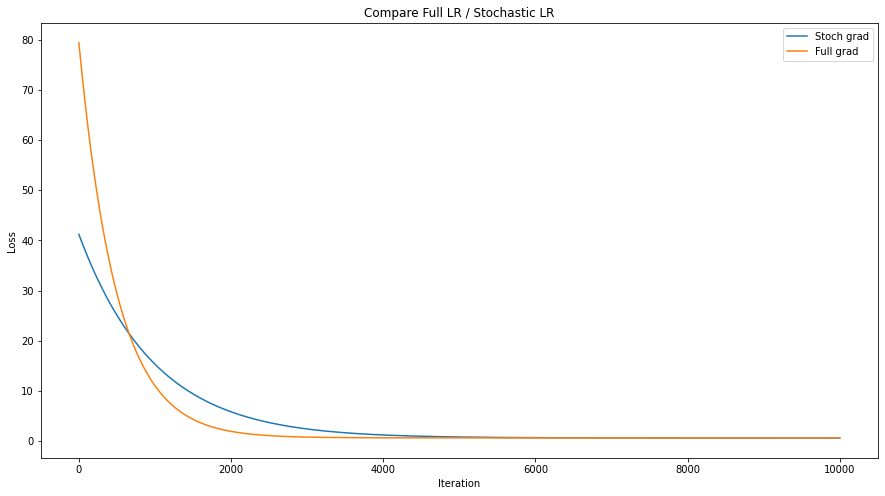

In [15]:
model_stoch = LogReg(w0=w0, max_iter=10000, gd_type='stochastic', lambda_1=1.0, lambda_2=0.5)
model_stoch.fit(X_train, y_train)


model_full = LogReg(w0=w0, max_iter=10000, gd_type='full', tolerance=10**(-7))
model_full.fit(X_train, y_train)

plt.figure(figsize = (15,8))
plt.title("Compare Full LR / Stochastic LR")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(model_stoch.loss_history, label = "Stoch grad")
plt.plot(model_full.loss_history, label = "Full grad")

plt.legend()
plt.show()

### График затраченного времени от номера итерации

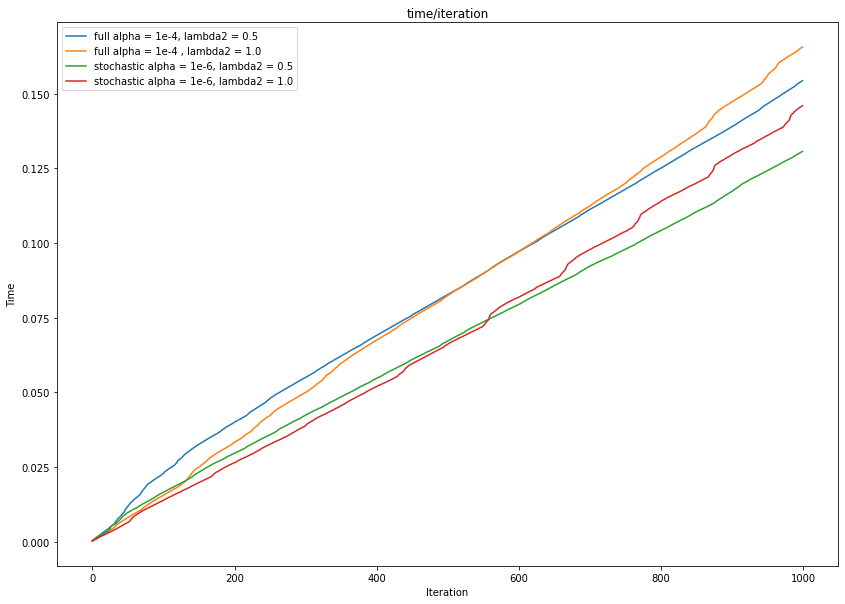

In [16]:
plt.figure(figsize=(14,10))
plt.title('time/iteration')
plt.xlabel('Iteration')
plt.ylabel('Time')

model = LogReg(w0=w0, lambda_1=0, lambda_2=0.5, gd_type='full', max_iter=1000, alpha=1e-4).fit(X, y)
plt.plot(model.time_history, label = 'full alpha = 1e-4, lambda2 = 0.5')

model = LogReg(w0=w0, lambda_1=0, lambda_2=1.0, gd_type='full', max_iter=1000, alpha=1e-4).fit(X, y)
plt.plot(model.time_history, label = 'full alpha = 1e-4 , lambda2 = 1.0')

model = LogReg(w0=w0, lambda_1=0, lambda_2=0.5, gd_type='stochastic', max_iter=1000, alpha=1e-6).fit(X, y)
plt.plot(model.time_history, label = 'stochastic alpha = 1e-6, lambda2 = 0.5')

model = LogReg(w0=w0, lambda_1=0, lambda_2=1.0, gd_type='stochastic', max_iter=1000, alpha=1e-6).fit(X, y)
plt.plot(model.time_history, label = 'stochastic alpha = 1e-6, lambda2 = 1.0')


plt.legend()
plt.show()

### Подбор оптимальной величины шага

In [18]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 
results = []
maximum = 0
alpha_params = [10**i for i in np.linspace(-3, -1, num = 300)]
for alpha in alpha_params:
    model = LogReg(w0=w0, lambda_2=1.0, max_iter=1000, alpha = alpha, gd_type='full', tolerance = 1e-6)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    if average_precision_score(y_test, y_pred) > maximum:
        maximum = average_precision_score(y_test, y_pred)
        answer = alpha
    results.append(average_precision_score(y_test, y_pred))
print("Best alpha: ", answer)
print("Average_precision_score: ", maximum)

Best alpha:  0.004253657732750387
Average_precision_score:  0.8791614122175377


__Выводы:__ Оптимальная величина шага = 0.004

__Задание 2.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.

Полезные функции и классы из scikit-learn для этого задания: confusion_matrix, precision_recall_curve, average_precision_score, train_test_split, StandardScaler, roc-curve, roc_auc_score.

Возьмём данные конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [19]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [20]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучите логистическую регрессию с удобными для вас параметрами. Сделайте предсказание на тестовой части выборки.

In [22]:
n, m = X_train.shape
w0 = np.random.uniform(low=-20, high=20, size=(m,))
model = LogReg(w0=w0, max_iter=10000, gd_type='full', tolerance=10**(-7))

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

Постройку ROC-кривую и Precision-Recall-кривую, посчитайте ROC-AUC и PR-AUC. Какие наблюдения и выводы по ним можно сделать? (В свободной форме)

In [23]:
from sklearn.metrics import average_precision_score, roc_auc_score

roc = roc_auc_score(y_test, y_pred)
pr = average_precision_score(y_test, y_pred)
print("ROC-AUC: ", roc)
print("PR-AUC: ", pr)

ROC-AUC:  0.6197244533240321
PR-AUC:  0.6040672966557276


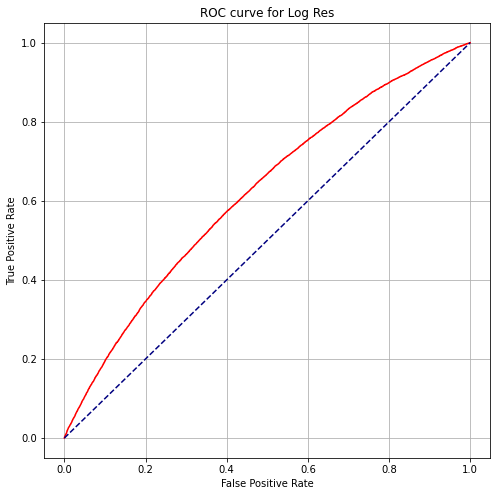

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, threshold = roc_curve(y_test, y_pred) 
plt.figure(figsize=(8,8))
plt.plot(fpr,tpr, color='r', label='Log Res') 
plt.title('ROC curve for Log Res') 
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.grid()

Text(0.5, 1.0, 'Precision-Recall curve')

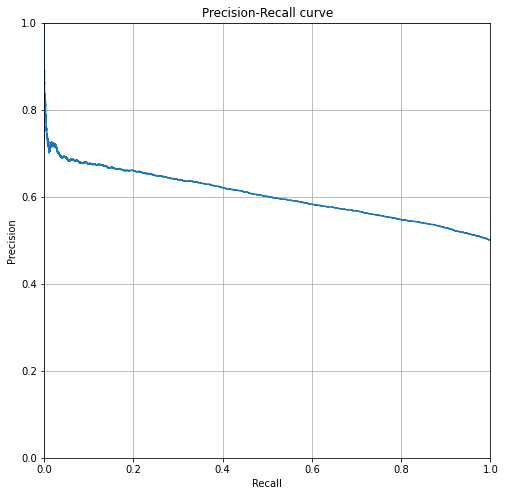

In [27]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8,8))
plt.step(recall, precision)   
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0]) 
plt.grid()
plt.title('Precision-Recall curve')

Предположим, что наш алгоритм должен обеспечивать полноту не менее 0.7. Какому порогу бинаризации вероятностей это будет соответствовать? Какую точность (precision) мы получим? Постройте матрицу ошибок для данного порога. Что вы можете сказать о таком алгоритме? (В свободной форме)

In [28]:
from sklearn.metrics import confusion_matrix

thr = threshold[np.where(recall>=0.7)[0][-1]]
print('Threshold: ', thr)
prec = precision[np.where(recall>=0.7)[0][-1]]
print('Precision: ', prec)
conf = confusion_matrix(y_test, y_pred>thr)
print('Confusion matrix: \n', conf)

Threshold:  0.47731826404830824
Precision:  0.5676824027374601
Confusion matrix: 
 [[13743 36251]
 [ 7502 42504]]


__Задание 3.__ Изучение влияния регуляризатора на процесс обучения

Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

## Часть 3. Метод опорных векторов

__Задание 1.__ Обучение и применение метода опорных векторов.

Обучите метод опорных векторов (в этот раз воспользуйтесь готовой реализацией LinearSVC из sklearn). Используйте уже загруженные и обработанные в предыдущей части данные.

In [29]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_score = svc.decision_function(X_test)

/home/di/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


На той же тестовой части посчитайте все те же метрики. Что вы можете сказать о полученных результатах?

ROC-AUC:  0.5876249500617992


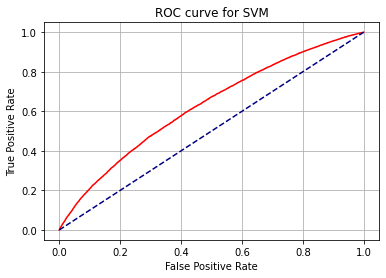

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_score) 
plt.plot(fpr,tpr, color='r', label='SVM') 
plt.title('ROC curve for SVM') 
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.grid()

roc = roc_auc_score(y_test, y_pred)
print("ROC-AUC: ", roc)



PR-AUC:  0.5522398237623639


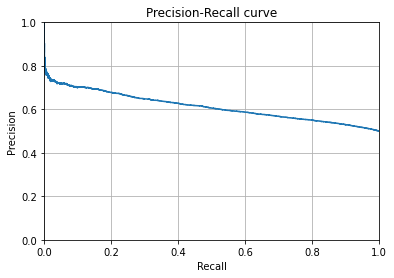

In [32]:
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.step(recall, precision)  
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0]) 
plt.grid()
plt.title('Precision-Recall curve')
pr = average_precision_score(y_test, y_pred)
print("PR-AUC: ", pr)

В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов с линейным ядром. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром, так как только в нём есть информация об опорных векторах.

In [33]:
from sklearn.svm import SVC

X, y = make_classification(n_samples=100, n_features=4, n_informative=2)
model = SVC(C=0.1, kernel='linear')
model.fit(X, y)

SVC(C=0.1, kernel='linear')

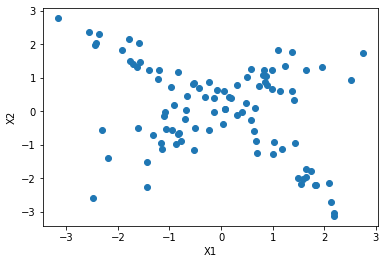

In [34]:
plt.scatter(X[:,0], X[:,1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

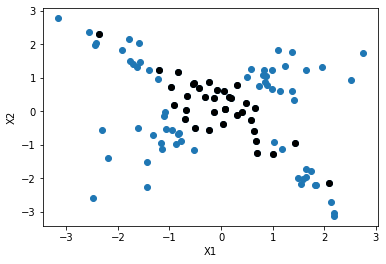

In [35]:
supportVec = model.support_vectors_

plt.scatter(X[:,0], X[:,1])
plt.scatter(supportVec[:,0], supportVec[:,1], color='black')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Часть 4. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.

In [ ]:
# Your code here
# ...

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

In [ ]:
# Your code here
# ...

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки. 